## Data Prep

In [13]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import logging
import warnings
from sklearn.metrics import mean_squared_error

logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('numexpr').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

/Users/chanelsun/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [5]:
data_clean = pd.read_csv('data_clean.csv',index_col=0, parse_dates=True)
data_clean['date'] = pd.to_datetime(data_clean['date'])
# log transform 
data_clean['new_cases_log'] = np.log(data_clean['new_cases'])
data_clean.head()

,date,location,new_cases,new_deaths,reproduction_rate,new_tests,stringency_index,population_density,aged_70_older,diabetes_prevalence,...,dayofmonth,weekofyear,new_cases_lag1,new_cases_lag7,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,new_cases_log
0,2020-03-21,Belgium,713.0,35.0,2.16,2276.0,81.48,375.564,12.849,4.29,...,21,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.569481
1,2020-03-22,Belgium,662.0,40.0,2.13,1414.0,81.48,375.564,12.849,4.29,...,22,12,713.0,0.0,0.0,0.0,0.0,0.0,0.0,6.495266
2,2020-03-23,Belgium,469.0,41.0,2.09,3322.0,81.48,375.564,12.849,4.29,...,23,13,662.0,0.0,0.0,0.0,0.0,0.0,0.0,6.150603
3,2020-03-24,Belgium,486.0,55.0,2.05,3975.0,81.48,375.564,12.849,4.29,...,24,13,469.0,0.0,0.0,0.0,0.0,0.0,0.0,6.186209
4,2020-03-25,Belgium,1328.0,81.0,2.01,4282.0,81.48,375.564,12.849,4.29,...,25,13,486.0,0.0,0.0,0.0,0.0,0.0,0.0,7.191429


In [6]:
data_clean['new_cases_log'].describe()
inf_count = np.isinf(data_clean['new_cases_log']).sum()
print(f"Number of '-inf' values: {inf_count}")
data_clean['new_cases_log'] = data_clean['new_cases_log'].replace(-np.inf, 0)

Number of '-inf' values: 5


In [8]:
# feature selection; see data prep for details
features_to_include = ['new_deaths', 'reproduction_rate', 'new_tests']

In [9]:
# account for lockdowns
from prophet.make_holidays import make_holidays_df
# Belgium 
belgium_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-20', 'lower_window': 0, 'ds_upper': '2020-05-13'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-06', 'lower_window': 0, 'ds_upper': '2021-04-26'}
])
for t_col in ['ds', 'ds_upper']:
    belgium_lockdowns[t_col] = pd.to_datetime(belgium_lockdowns[t_col])
belgium_lockdowns['upper_window'] = (belgium_lockdowns['ds_upper'] - belgium_lockdowns['ds']).dt.days
belgium_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Belgium')
holiday_belgium = pd.concat((belgium_lockdowns, belgium_holidays))
holiday_belgium = holiday_belgium.reset_index(drop=True)
holiday_belgium.loc[2:, 'ds_upper'] = holiday_belgium.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Denmark 
denmark_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': 0, 'ds_upper': '2020-04-15'}
])
for t_col in ['ds', 'ds_upper']:
    denmark_lockdowns[t_col] = pd.to_datetime(denmark_lockdowns[t_col])
denmark_lockdowns['upper_window'] = (denmark_lockdowns['ds_upper'] - denmark_lockdowns['ds']).dt.days
denmark_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Denmark')
holiday_denmark = pd.concat((denmark_lockdowns, denmark_holidays))
holiday_denmark = holiday_denmark.reset_index(drop=True)
holiday_denmark.loc[2:, 'ds_upper'] = holiday_denmark.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Finland
finland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-16', 'lower_window': 0, 'ds_upper': '2020-05-13'},
    {'holiday': 'lockdown_2', 'ds': '2021-03-08', 'lower_window': 0, 'ds_upper': '2021-03-30'}
])
for t_col in ['ds', 'ds_upper']:
    finland_lockdowns[t_col] = pd.to_datetime(finland_lockdowns[t_col])
finland_lockdowns['upper_window'] = (finland_lockdowns['ds_upper'] - finland_lockdowns['ds']).dt.days
finland_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Finland')
holiday_finland = pd.concat((finland_lockdowns, finland_holidays))
holiday_finland = holiday_finland.reset_index(drop=True)
holiday_finland.loc[2:, 'ds_upper'] = holiday_finland.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Ireland
ireland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': 0, 'ds_upper': '2020-05-18'},
    {'holiday': 'lockdown_2', 'ds': '2021-01-26', 'lower_window': 0, 'ds_upper': '2021-03-19'}
])
for t_col in ['ds', 'ds_upper']:
    ireland_lockdowns[t_col] = pd.to_datetime(ireland_lockdowns[t_col])
ireland_lockdowns['upper_window'] = (ireland_lockdowns['ds_upper'] - ireland_lockdowns['ds']).dt.days
ireland_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Ireland')
holiday_ireland = pd.concat((ireland_lockdowns, ireland_holidays))
holiday_ireland = holiday_ireland.reset_index(drop=True)
holiday_ireland.loc[2:, 'ds_upper'] = holiday_ireland.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Italy
italy_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-08', 'lower_window': 0, 'ds_upper': '2020-05-04'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-04', 'lower_window': 0, 'ds_upper': '2021-01-06'}
])
for t_col in ['ds', 'ds_upper']:
    italy_lockdowns[t_col] = pd.to_datetime(italy_lockdowns[t_col])
italy_lockdowns['upper_window'] = (italy_lockdowns['ds_upper'] - italy_lockdowns['ds']).dt.days
italy_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Italy')
holiday_italy = pd.concat((italy_lockdowns, italy_holidays))
holiday_italy = holiday_italy.reset_index(drop=True)
holiday_italy.loc[2:, 'ds_upper'] = holiday_italy.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Lithuania
lithuania_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-12', 'lower_window': 0, 'ds_upper': '2020-04-16'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-07', 'lower_window': 0, 'ds_upper': '2021-12-31'}
])
for t_col in ['ds', 'ds_upper']:
    lithuania_lockdowns[t_col] = pd.to_datetime(lithuania_lockdowns[t_col])
lithuania_lockdowns['upper_window'] = (lithuania_lockdowns['ds_upper'] - lithuania_lockdowns['ds']).dt.days
lithuania_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Lithuania')
holiday_lithuania = pd.concat((lithuania_lockdowns, lithuania_holidays))
holiday_lithuania = holiday_lithuania.reset_index(drop=True)
holiday_lithuania.loc[2:, 'ds_upper'] = holiday_lithuania.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Norway
norway_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-12', 'lower_window': 0, 'ds_upper': '2020-05-08'}
])
for t_col in ['ds', 'ds_upper']:
    norway_lockdowns[t_col] = pd.to_datetime(norway_lockdowns[t_col])
norway_lockdowns['upper_window'] = (norway_lockdowns['ds_upper'] - norway_lockdowns['ds']).dt.days
norway_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Norway')
holiday_norway = pd.concat((norway_lockdowns, norway_holidays))
holiday_norway = holiday_norway.reset_index(drop=True)
holiday_norway.loc[2:, 'ds_upper'] = holiday_norway.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Poland
poland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-19', 'lower_window': 0, 'ds_upper': '2020-06-25'},
    {'holiday': 'lockdown_2', 'ds': '2020-12-28', 'lower_window': 0, 'ds_upper': '2021-01-31'},
    {'holiday': 'lockdown_3', 'ds': '2021-03-11', 'lower_window': 0, 'ds_upper': '2021-04-28'}
])
for t_col in ['ds', 'ds_upper']:
    poland_lockdowns[t_col] = pd.to_datetime(poland_lockdowns[t_col])
poland_lockdowns['upper_window'] = (poland_lockdowns['ds_upper'] - poland_lockdowns['ds']).dt.days
poland_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Poland')
holiday_poland = pd.concat((poland_lockdowns, poland_holidays))
holiday_poland = holiday_poland.reset_index(drop=True)
holiday_poland.loc[2:, 'ds_upper'] = holiday_poland.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Switzerland
swiss_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-19', 'lower_window': 0, 'ds_upper': '2020-06-25'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-01', 'lower_window': 0, 'ds_upper': '2021-09-21'},
    {'holiday': 'lockdown_3', 'ds': '2021-12-01', 'lower_window': 0, 'ds_upper': '2022-02-17'}
])
for t_col in ['ds', 'ds_upper']:
    swiss_lockdowns[t_col] = pd.to_datetime(swiss_lockdowns[t_col])
swiss_lockdowns['upper_window'] = (swiss_lockdowns['ds_upper'] - swiss_lockdowns['ds']).dt.days
switzerland_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Switzerland')
holiday_switzerland = pd.concat((swiss_lockdowns, switzerland_holidays))
holiday_switzerland = holiday_switzerland.reset_index(drop=True)
holiday_switzerland.loc[2:, 'ds_upper'] = holiday_switzerland.loc[2:, 'ds'] + pd.Timedelta(days=7)

# United Kingdom
uk_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-16', 'lower_window': 0, 'ds_upper': '2020-06-01'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-05', 'lower_window': 0, 'ds_upper': '2020-12-02'},
    {'holiday': 'lockdown_3', 'ds': '2021-01-06', 'lower_window': 0, 'ds_upper': '2022-03-08'}
])
for t_col in ['ds', 'ds_upper']:
    uk_lockdowns[t_col] = pd.to_datetime(uk_lockdowns[t_col])
uk_lockdowns['upper_window'] = (uk_lockdowns['ds_upper'] - uk_lockdowns['ds']).dt.days
uk_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='UK')
holiday_unitedkingdom = pd.concat((uk_lockdowns, uk_holidays))
holiday_unitedkingdom = holiday_unitedkingdom.reset_index(drop=True)
holiday_unitedkingdom.loc[2:, 'ds_upper'] = holiday_unitedkingdom.loc[2:, 'ds'] + pd.Timedelta(days=7)

## Prophet Single

### Italy Model Development

In [10]:
data_italy = data_clean[data_clean['location'] == 'Italy']
data_italy = data_italy.drop(['location'], axis=1)
data_italy.head()

,date,new_cases,new_deaths,reproduction_rate,new_tests,stringency_index,population_density,aged_70_older,diabetes_prevalence,female_smokers,...,dayofmonth,weekofyear,new_cases_lag1,new_cases_lag7,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,new_cases_log
4064,2020-03-21,5986.0,627.0,1.63,26336.0,85.19,205.859,16.24,4.78,19.8,...,21,12,970.0,615.0,762.0,1195.428571,2138.148253,849.500000,1504.832204,8.697179
4065,2020-03-22,6557.0,793.0,1.53,25180.0,85.19,205.859,16.24,4.78,19.8,...,22,12,5986.0,728.0,615.0,2028.142857,2918.450926,1281.785714,2135.405607,8.788288
4066,2020-03-23,5560.0,651.0,1.45,17066.0,85.19,205.859,16.24,4.78,19.8,...,23,13,6557.0,199.0,728.0,2794.000000,3058.502520,1668.428571,2389.108676,8.623353
4067,2020-03-24,4789.0,601.0,1.38,21496.0,85.19,205.859,16.24,4.78,19.8,...,24,13,5560.0,252.0,199.0,3442.142857,2907.010574,1994.500000,2486.347329,8.474077
4068,2020-03-25,5249.0,743.0,1.30,27481.0,85.19,205.859,16.24,4.78,19.8,...,25,13,4789.0,110.0,252.0,4176.285714,2552.549687,2329.928571,2591.460457,8.565793


In [11]:
split_date = '2023-01-01'
train_italy = data_italy[data_italy['date'] < split_date]
test_italy = data_italy[data_italy['date'] >= split_date]

16:40:38 - cmdstanpy - INFO - Chain [1] start processing
16:40:39 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 8793.999094778701
Test RMSE: 8793.511369949301


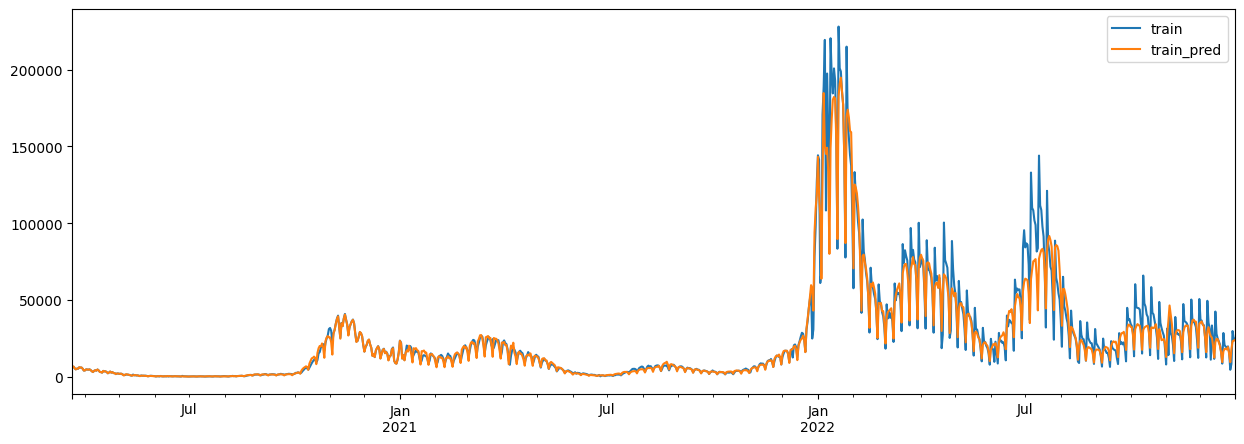

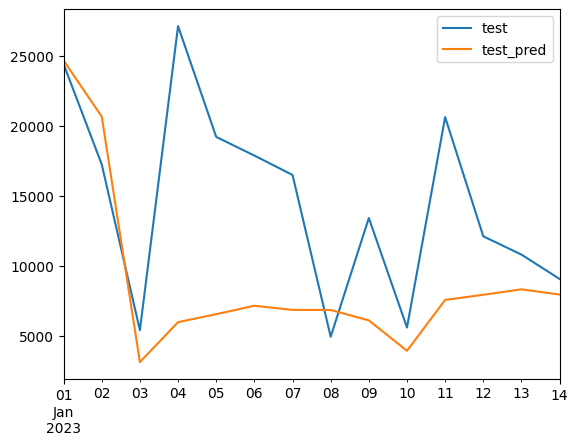

In [17]:
model_italy = Prophet(
            holidays=holiday_italy,
            holidays_prior_scale = 0.1,
            seasonality_prior_scale = 1,
            changepoint_prior_scale = 10,
            seasonality_mode = 'additive'
             )
for col in features_to_include:
    model_italy.add_regressor(col)
model_italy.fit(train_italy.rename(columns={'date':'ds', 'new_cases_log':'y'}))

train_pred=model_italy.predict(train_italy.reset_index().rename(columns={'date':'ds', 'new_cases_log':'y'})).set_index('ds')
train_pred['yhat_exp'] = np.exp(train_pred['yhat'])
pd.concat([train_italy.set_index('date')['new_cases'],train_pred['yhat_exp']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

test_pred=model_italy.predict(test_italy.reset_index().rename(columns={'date':'ds', 'new_cases_log':'y'})).set_index('ds')
test_pred['yhat_exp'] = np.exp(test_pred['yhat'])
pd.concat([test_italy.set_index('date')['new_cases'],test_pred['yhat_exp']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

train_rmse_italy = np.sqrt(mean_squared_error(train_italy['new_cases'], train_pred['yhat_exp']))
test_rmse_italy = np.sqrt(mean_squared_error(test_italy['new_cases'], test_pred['yhat_exp']))
print(f'Train RMSE: {train_rmse_italy}')
print(f'Test RMSE: {test_rmse_italy}')

### Cross Validation
https://zerotomastery.io/blog/time-series-forecasting-with-facebook-prophet/#:~:text=Cross%2Dvalidation%20is%20an%20important,on%20the%20corresponding%20testing%20set.


In [18]:
#Parameter Grid
from sklearn.model_selection import ParameterGrid
from prophet.diagnostics import cross_validation, performance_metrics
param_grid = {'seasonality_mode': ["additive", 'multiplicative'],
              'seasonality_prior_scale': [1, 5, 10, 20],
              'holidays_prior_scale': [5, 10, 20, 25],
              'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
len(list(grid))

#Store the results
rmse = []
#Loop
for params in grid:
  #model
  m = Prophet(holidays = holiday_italy,
              seasonality_mode = params['seasonality_mode'],
              seasonality_prior_scale = params['seasonality_prior_scale'],
              holidays_prior_scale = params['holidays_prior_scale'],
              changepoint_prior_scale = params['changepoint_prior_scale'])
  for col in features_to_include:
    m.add_regressor(col)
  m.fit(train_italy.rename(columns={'date':'ds', 'new_cases_log':'y'}))

  #CV
  df_cv = cross_validation(m,
                          horizon = '14 days',
                          period = '100 days',
                          initial = '365 days',
                          parallel = 'processes')

  #Measure the error and store the result
  error = performance_metrics(df_cv)["rmse"].mean()
  rmse.append(error)

16:41:22 - cmdstanpy - INFO - Chain [1] start processing
16:41:23 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:41:24 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
16:41:24 - cmdstanpy - INFO - Chain [1] done processing
16:41:24 - cmdstanpy - INFO - Chain [1] start processing
16:41:24 - cmdstanpy - INFO - Chain [1] start processing
16:41:24 - cmdstanpy - INFO - Chain [1] start processing
16:41:24 - cmdstanpy - INFO - Chain [1] start processing
16:41:24 - cmdstanpy - INFO - Chain [1] start processing
16:41:24 - cmdstanpy - INFO - Chain [1] done processing
16:41:24 - cmdstanpy - INFO

In [19]:
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
best_params

,105
changepoint_prior_scale,0.1
holidays_prior_scale,10
seasonality_mode,additive
seasonality_prior_scale,5
rmse,0.481442


16:50:20 - cmdstanpy - INFO - Chain [1] start processing
16:50:20 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 13569.740353446954
Test RMSE: 9123.104748504778


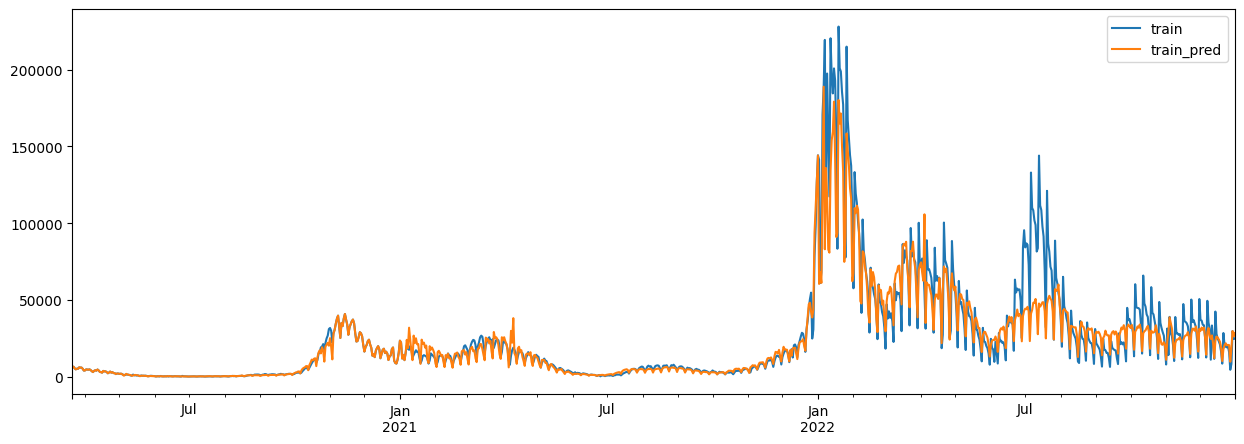

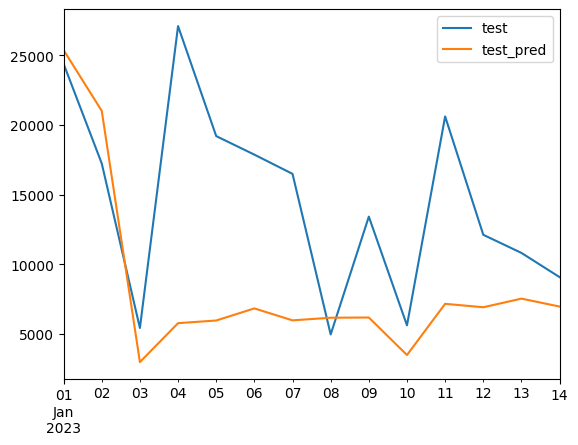

In [20]:
model_italy_cv = Prophet(
            holidays=holiday_italy,
            holidays_prior_scale = 10,
            seasonality_prior_scale = 5,
            changepoint_prior_scale = 0.1,
            seasonality_mode = 'additive'
             )
for col in features_to_include:
    model_italy_cv.add_regressor(col)
model_italy_cv.fit(train_italy.rename(columns={'date':'ds', 'new_cases_log':'y'}))

train_pred=model_italy_cv.predict(train_italy.reset_index().rename(columns={'date':'ds', 'new_cases_log':'y'})).set_index('ds')
train_pred['yhat_exp'] = np.exp(train_pred['yhat'])
pd.concat([train_italy.set_index('date')['new_cases'],train_pred['yhat_exp']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

test_pred=model_italy_cv.predict(test_italy.reset_index().rename(columns={'date':'ds', 'new_cases_log':'y'})).set_index('ds')
test_pred['yhat_exp'] = np.exp(test_pred['yhat'])
pd.concat([test_italy.set_index('date')['new_cases'],test_pred['yhat_exp']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

train_rmse_italy = np.sqrt(mean_squared_error(train_italy['new_cases'], train_pred['yhat_exp']))
test_rmse_italy = np.sqrt(mean_squared_error(test_italy['new_cases'], test_pred['yhat_exp']))
print(f'Train RMSE: {train_rmse_italy}')
print(f'Test RMSE: {test_rmse_italy}')


### Other countries

17:01:44 - cmdstanpy - INFO - Chain [1] start processing
17:01:45 - cmdstanpy - INFO - Chain [1] done processing
17:01:45 - cmdstanpy - INFO - Chain [1] start processing


Belgium - Train RMSE: 2664.4240859289134, Test RMSE: 389.2844522829854, Test SRMSE: 65.73371525704735


17:01:46 - cmdstanpy - INFO - Chain [1] done processing
17:01:46 - cmdstanpy - INFO - Chain [1] start processing


Denmark - Train RMSE: 3266.6788546890953, Test RMSE: 269.1650724155473, Test SRMSE: 45.84877739162504


17:01:46 - cmdstanpy - INFO - Chain [1] done processing


Finland - Train RMSE: 689.8999323871171, Test RMSE: 144.62692408350492, Test SRMSE: 109.98245177452846


17:01:47 - cmdstanpy - INFO - Chain [1] start processing
17:01:47 - cmdstanpy - INFO - Chain [1] done processing


Ireland - Train RMSE: 1793.2145868682956, Test RMSE: 346.61991452088057, Test SRMSE: 76.84368651294264


17:01:48 - cmdstanpy - INFO - Chain [1] start processing
17:01:48 - cmdstanpy - INFO - Chain [1] done processing


Italy - Train RMSE: 15293.941133009901, Test RMSE: 10509.94143664907, Test SRMSE: 71.99083112986553


17:01:49 - cmdstanpy - INFO - Chain [1] start processing
17:01:49 - cmdstanpy - INFO - Chain [1] done processing
17:01:50 - cmdstanpy - INFO - Chain [1] start processing


Lithuania - Train RMSE: 1229.9751051820713, Test RMSE: 327.43889896339033, Test SRMSE: 110.83521725066403


17:01:50 - cmdstanpy - INFO - Chain [1] done processing


Norway - Train RMSE: 1149.605514399983, Test RMSE: 71.46447815803238, Test SRMSE: 55.27639194543941


17:01:51 - cmdstanpy - INFO - Chain [1] start processing
17:01:51 - cmdstanpy - INFO - Chain [1] done processing


Poland - Train RMSE: 4964.429169497241, Test RMSE: 257.22276669863476, Test SRMSE: 75.4951516515909


17:01:52 - cmdstanpy - INFO - Chain [1] start processing
17:01:53 - cmdstanpy - INFO - Chain [1] done processing
17:01:54 - cmdstanpy - INFO - Chain [1] start processing


Switzerland - Train RMSE: 867.0697964357264, Test RMSE: 493.4659359430859, Test SRMSE: 168.1314943588027


17:01:54 - cmdstanpy - INFO - Chain [1] done processing


United Kingdom - Train RMSE: 7152.642220440097, Test RMSE: 1678.5918098132609, Test SRMSE: 41.29086927185869
                  train_rmse     test_rmse  test_srmse
Belgium          2664.424086    389.284452   65.733715
Denmark          3266.678855    269.165072   45.848777
Finland           689.899932    144.626924  109.982452
Ireland          1793.214587    346.619915   76.843687
Italy           15293.941133  10509.941437   71.990831
Lithuania        1229.975105    327.438899  110.835217
Norway           1149.605514     71.464478   55.276392
Poland           4964.429169    257.222767   75.495152
Switzerland       867.069796    493.465936  168.131494
United Kingdom   7152.642220   1678.591810   41.290869


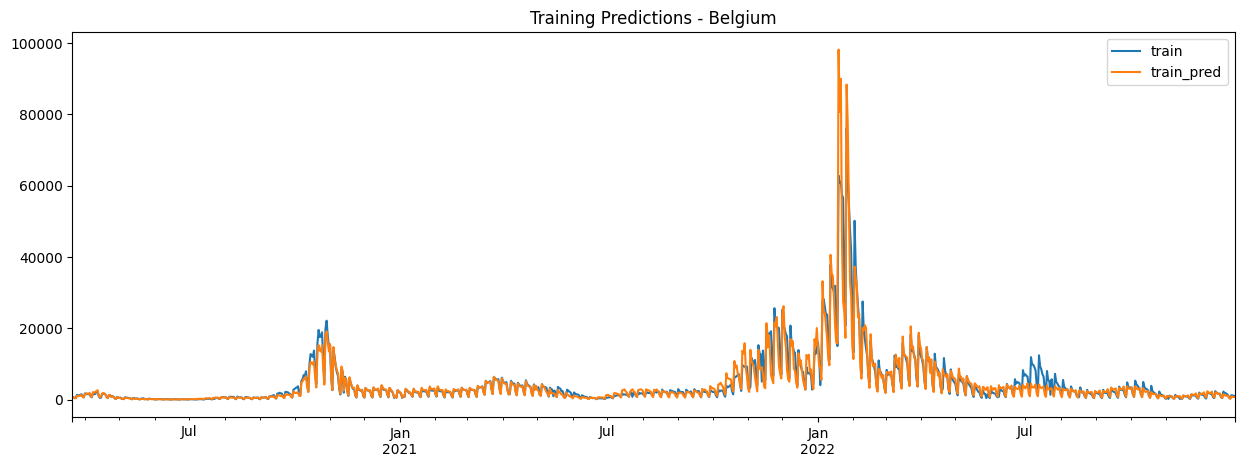

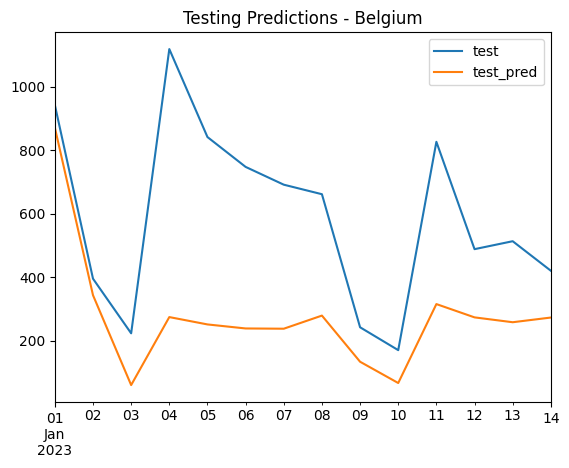

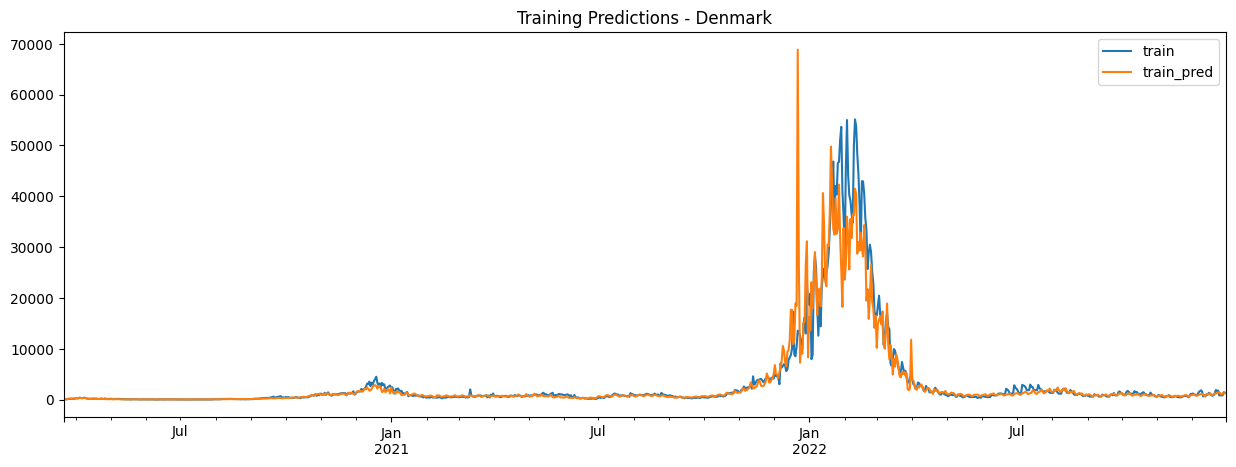

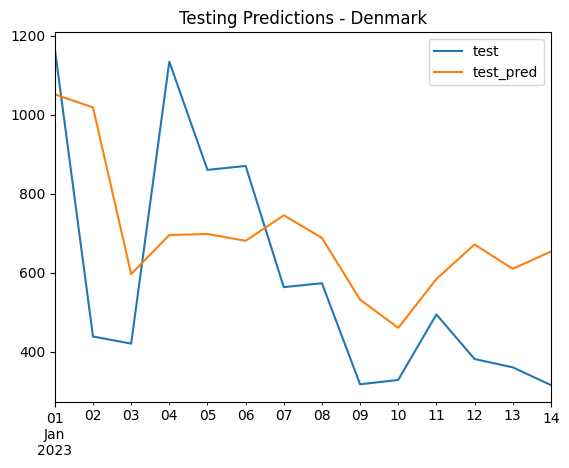

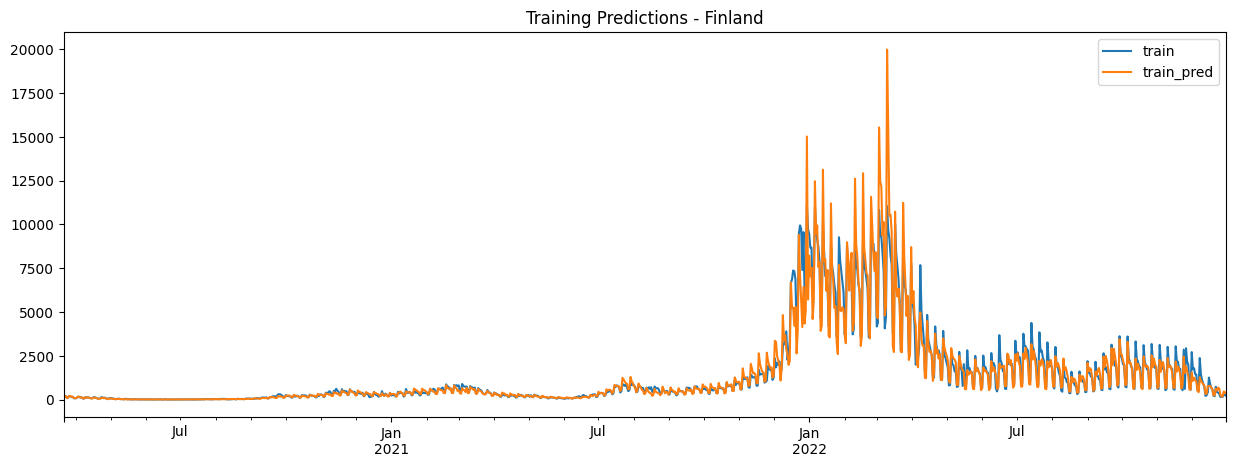

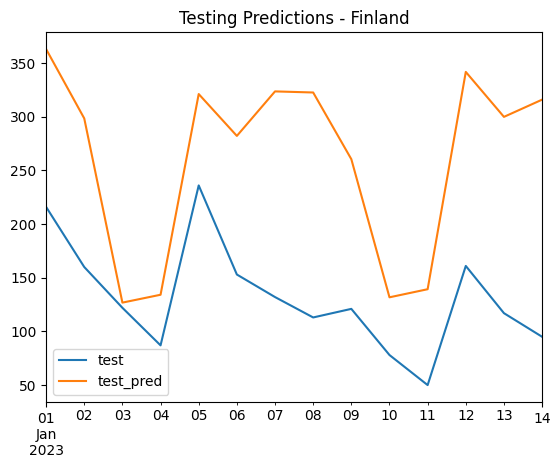

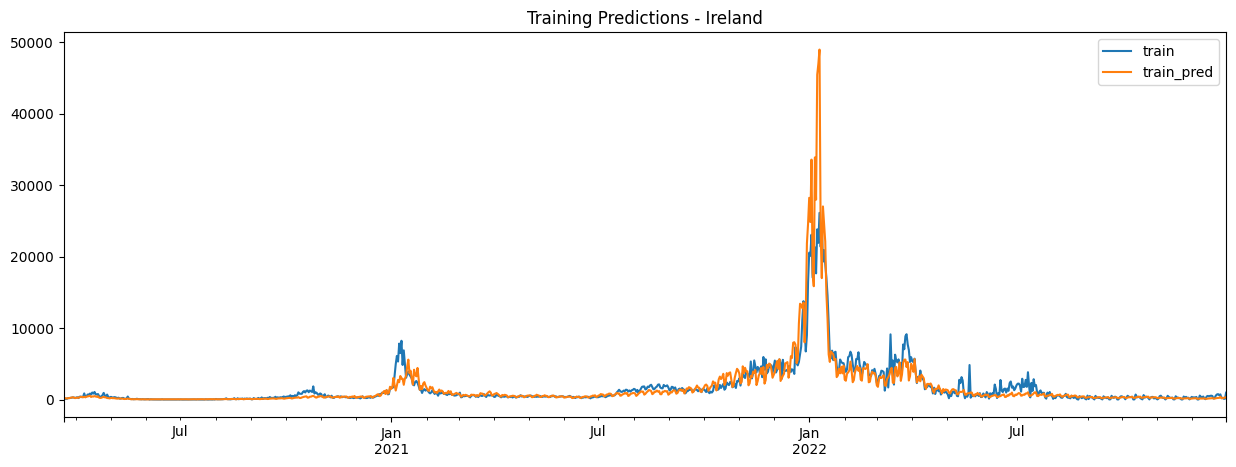

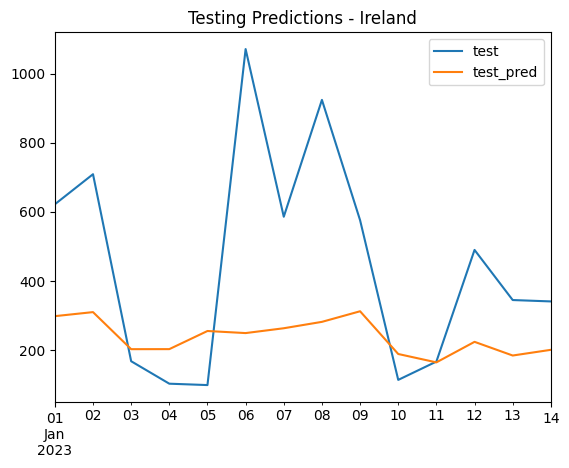

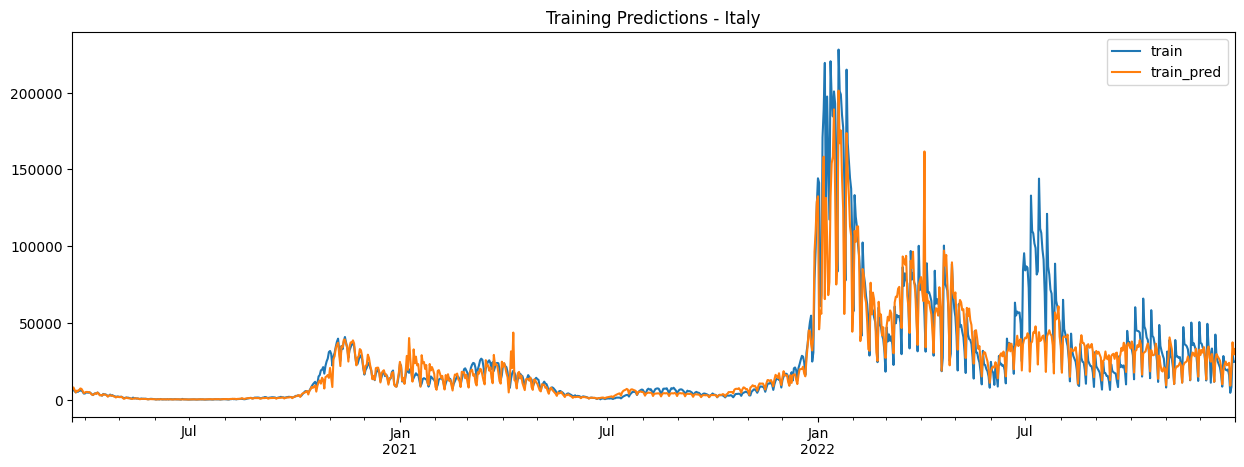

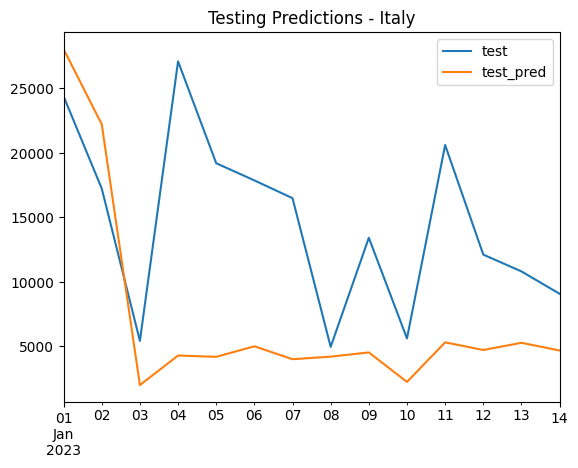

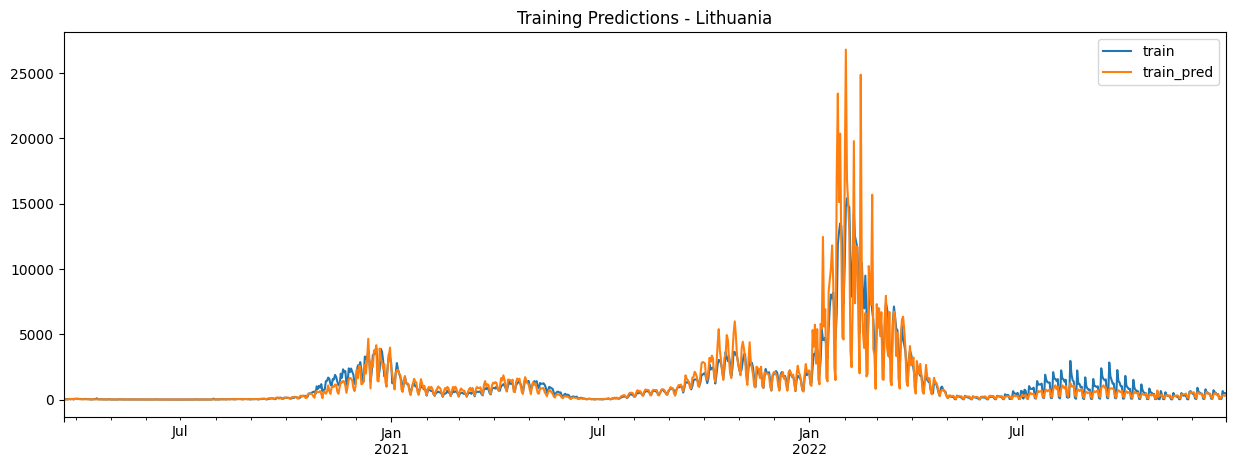

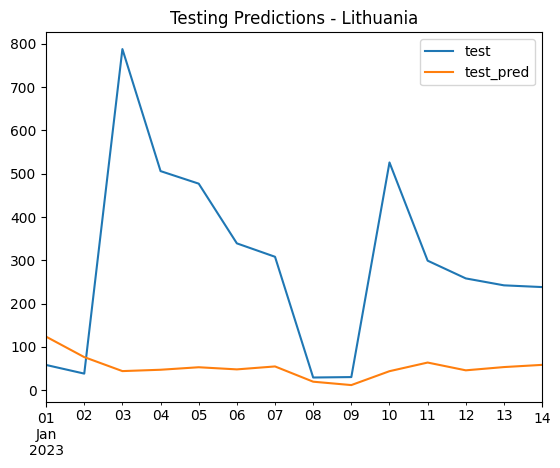

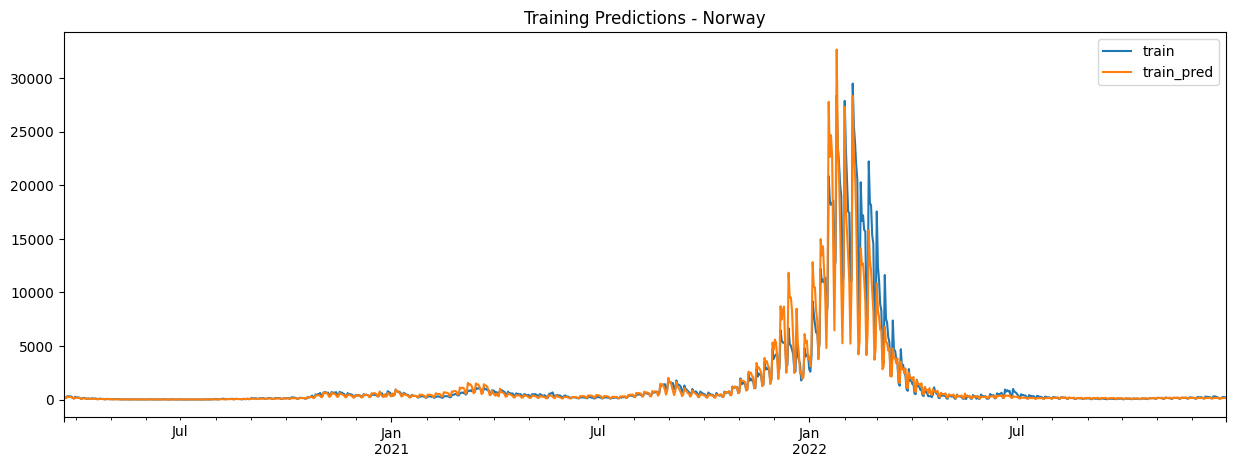

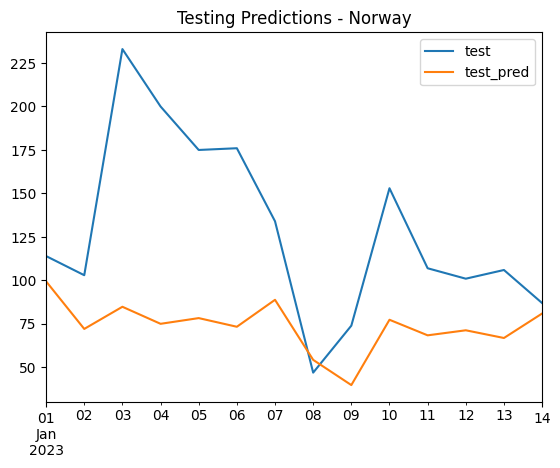

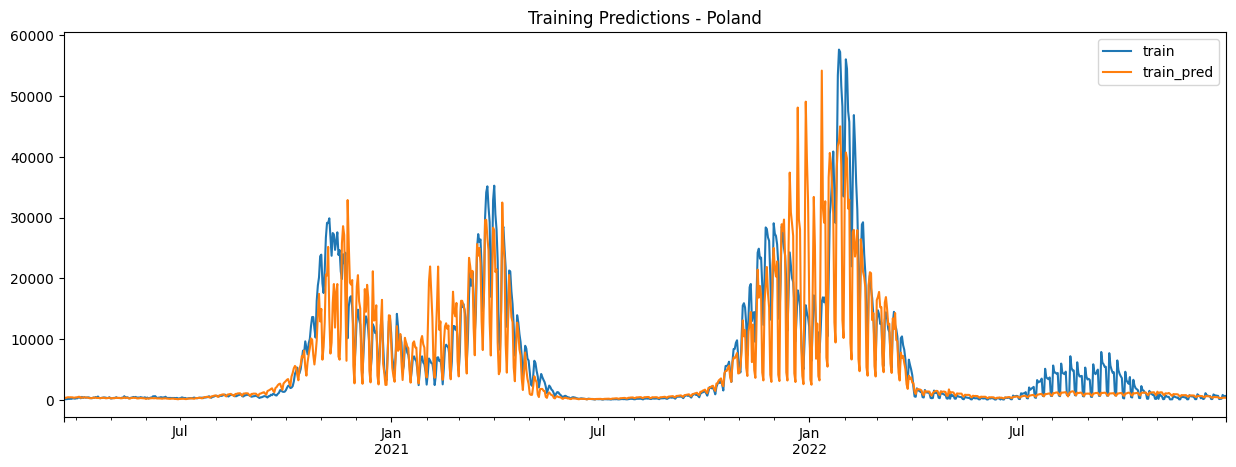

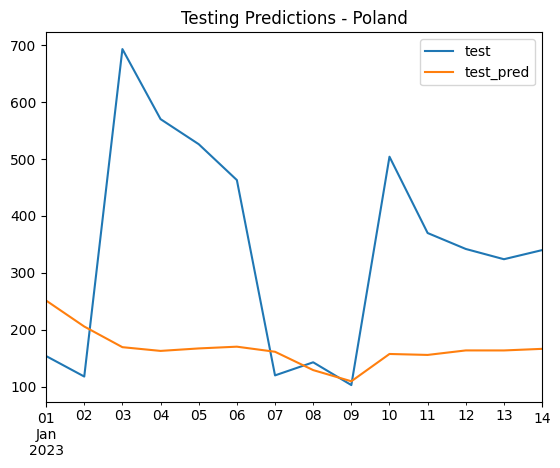

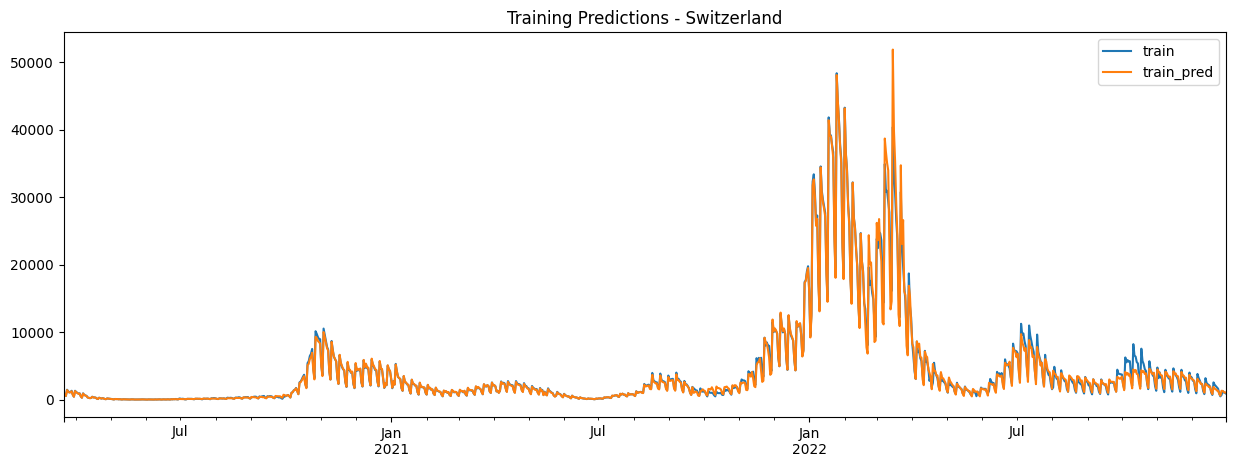

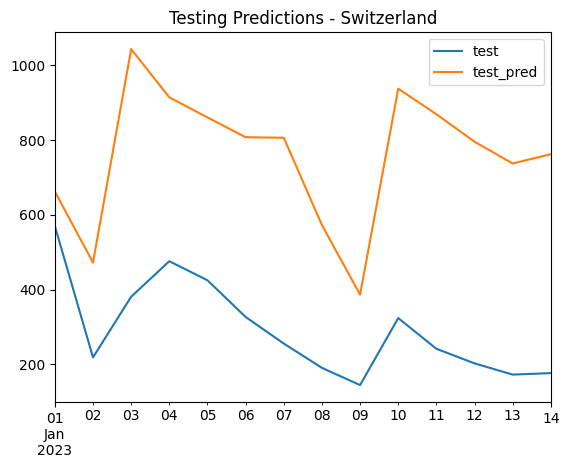

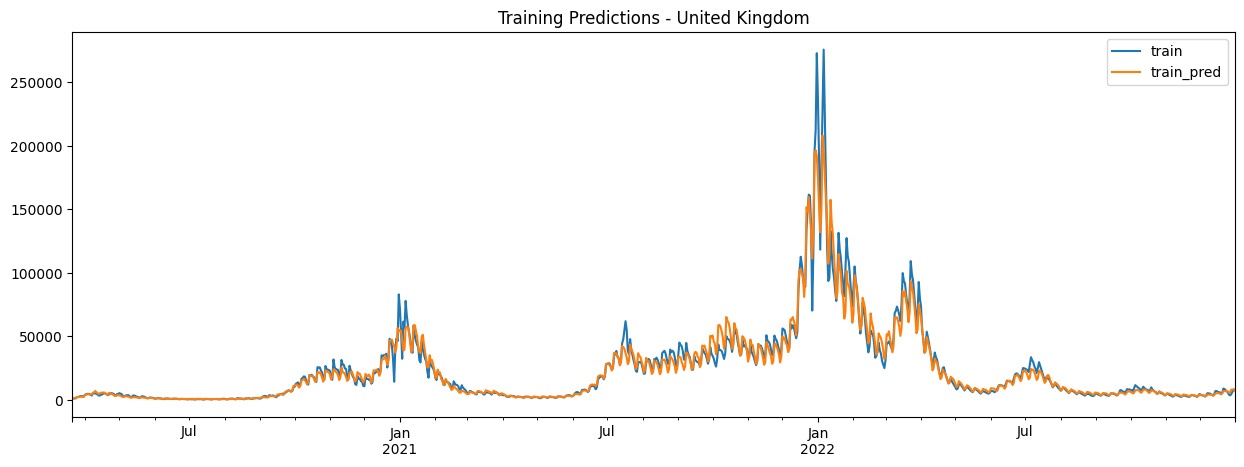

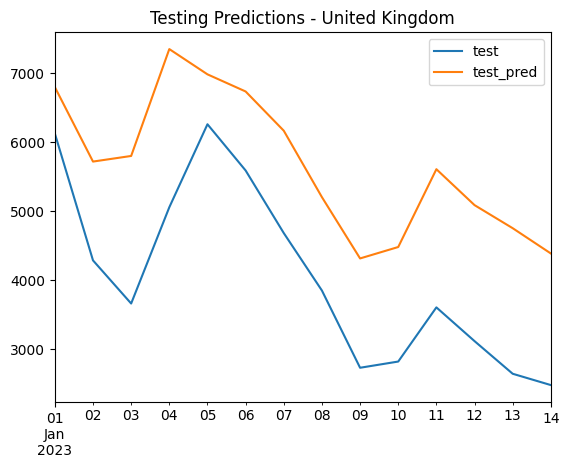

In [22]:
rmse_results = {}
data_clean['date'] = pd.to_datetime(data_clean['date'])
split_date = pd.to_datetime('2023-01-01')

for country in data_clean['location'].unique():
    data_country = data_clean[data_clean['location'] == country]
    data_country = data_country.drop(['location'], axis=1)
    train_country = data_country[data_country['date'] < split_date]
    test_country = data_country[data_country['date'] >= split_date]
    
    country_holidays = globals().get(f'holiday_{country.lower()}')

    # Create and fit the model with the parameters tuned for Italy
    model_country = Prophet(
        holidays=country_holidays,  
        holidays_prior_scale=0.1,
        seasonality_prior_scale=1,
        changepoint_prior_scale=0.05,
        seasonality_mode='multiplicative'
    )
    for col in features_to_include:
        model_country.add_regressor(col)
    model_country.fit(train_country.rename(columns={'date': 'ds', 'new_cases_log': 'y'}))

    # training preds
    train_pred = model_country.predict(train_country.reset_index().rename(columns={'date': 'ds', 'new_cases_log': 'y'})).set_index('ds')
    train_pred['yhat_exp'] = np.exp(train_pred['yhat'])
    pd.concat([train_country.set_index('date')['new_cases'],train_pred['yhat_exp']], axis=1).plot(figsize=(15,5)) 
    plt.title(f'Training Predictions - {country}')
    plt.legend(['train', 'train_pred'])

    # tests preds
    test_pred = model_country.predict(test_country.reset_index().rename(columns={'date': 'ds', 'new_cases_log': 'y'})).set_index('ds')
    test_pred['yhat_exp'] = np.exp(test_pred['yhat'])
    pd.concat([test_country.set_index('date')['new_cases'],test_pred['yhat_exp']], axis=1).plot( )
    plt.title(f'Testing Predictions - {country}')
    plt.legend(['test', 'test_pred'])

    # RMSE for training and testing sets
    train_rmse = np.sqrt(mean_squared_error(train_country['new_cases'], train_pred['yhat_exp']))
    test_rmse = np.sqrt(mean_squared_error(test_country['new_cases'], test_pred['yhat_exp']))
    test_srmse = test_rmse / np.mean(test_country['new_cases']) * 100
    rmse_results[country] = {'train_rmse': train_rmse, 'test_rmse': test_rmse, 'test_srmse': test_srmse}
    print(f"{country} - Train RMSE: {train_rmse}, Test RMSE: {test_rmse}, Test SRMSE: {test_srmse}")

rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)
